In [1]:
'''
- Trying 2x Crops and 30000 False Images (basically dataset is now 2x of previous iteration). 
- Bigger batch size=256
'''
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import h5py
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from PreProcessing import image_preprocessings as PreProcImg
from PreProcessing import digitStruct

%load_ext autoreload
%autoreload 2

#### Some pre-reqs and assumptions

In [2]:
max_recognizable_digits = 5
rotationRange = 45 # random rotation of images

### Preprocessing

In [3]:
# transform_label = lambda label: label if label!=10 else 0 # transform 10 to 0
# df_main = digitStruct.getMain_DigitStruct_DataFrame(max_recognizable_digits = max_recognizable_digits, 
#                                                     transform_label=transform_label)

#### Store Data in Disk for fast retreival

In [4]:
# store_df_main = pd.HDFStore('store_df_main.h5')
# store_df_main.put('df_main', df_main)
# store_df_main.close()

#### Load main, virgin, data from disk

In [5]:
with pd.HDFStore('store_df_main.h5') as store_df_main:
    df_main = store_df_main.get('df_main')

print('Dataframe shape',df_main.shape)

Dataframe shape (33402, 4)


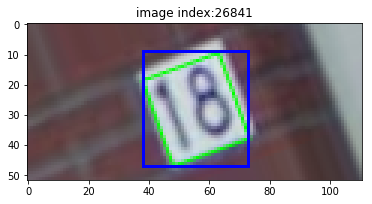

In [6]:
processimages= PreProcImg.ProcessImageDF(df_main)

i_image = np.random.choice(df_main.shape[0])
bbox_xmin, bbox_xmax, bbox_ymin, bbox_ymax = processimages.get_bbox_corners(i_image)
image = df_main.iloc[i_image]['image']

image = cv2.rectangle(image, (bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax), (0,255,0),1)

rotationAngle=20
rows, cols, n_channels = image.shape
h, w = bbox_ymax - bbox_ymin, bbox_xmax - bbox_xmin
x_rotation_center, y_rotation_center = int(round(bbox_xmin + w / 2.)), int(round(bbox_ymin + h / 2.)) # rotate about digits center
M = cv2.getRotationMatrix2D((x_rotation_center, y_rotation_center), rotationAngle, 1)
image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
# Minv = cv2.invertAffineTransform(M)
bbox_xmin, bbox_xmax, bbox_ymin, bbox_ymax = processimages.get_bboxCoords_afterRotation(M, 
                                                                          bbox_xmin, bbox_xmax, 
                                                                          bbox_ymin, bbox_ymax)

image = cv2.rectangle(image, (bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax), (255,0,0),1)
plt.imshow(image[...,[2,1,0]])
plt.title('image index:{}'.format(i_image))
plt.show()

#### Data Viz

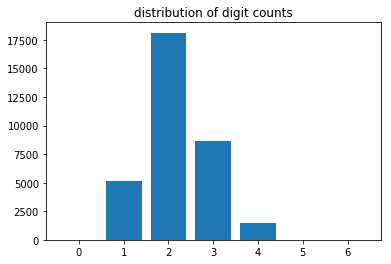

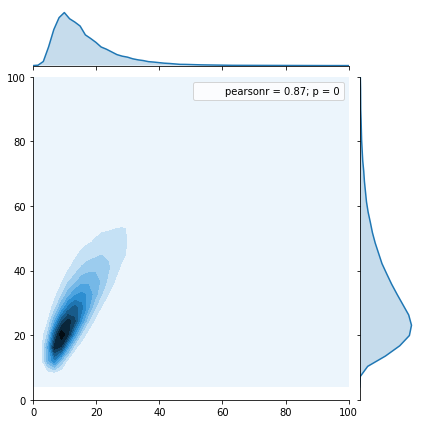

In [7]:
import seaborn as sns

counts=[]
for i in range(df_main['N'].max()+1):
    counts.append(np.sum(df_main['N']==i))
plt.bar(range(df_main['N'].max()+1), counts)
plt.title('distribution of digit counts')
plt.show()

# plot some images
img=df_main.iloc[0]['image']
bbox=df_main.iloc[0]['bb']
N=df_main.iloc[0]['N']

bboxe_s=df_main['bb'].values
N_s=df_main['N'].values

w_h=np.zeros(2)
for i in range(bboxe_s.shape[0]):
    w_h = np.vstack((w_h, bboxe_s[i][0:N_s[i], [2,3]]))
w_h=w_h[1:]
sns.jointplot(x=w_h[:, 0], y=w_h[:, 1], kind='kde', xlim=(0,100), ylim=(0,100))
plt.show()

### Shrink images to 32x32

In [8]:
# processimages = PreProcImg.ProcessImageDF(df_main)
# df_32x32 = processimages.getDF_with_resized_images_aroundBB(size=32, 
#                                                             max_recognizable_digits=5,
#                                                             max_randomExpansion=(0.4,0.6), 
#                                                             augment_With_randomExpansion=True,
#                                                             rotationRange=rotationRange)

#### Store shrunken images on disk

In [9]:
# store_df_32x32 = pd.HDFStore('store_df_32x32.h5')
# store_df_32x32.put('df_32x32', df_32x32)
# store_df_32x32.close()

#### load shrunken images (32x32)

In [10]:
with pd.HDFStore('store_df_32x32.h5') as store_df_32x32:
    df_32x32 = store_df_32x32.get('df_32x32')

print('Dataframe shape',df_32x32.shape)

Dataframe shape (66804, 5)


#### Visualize some images

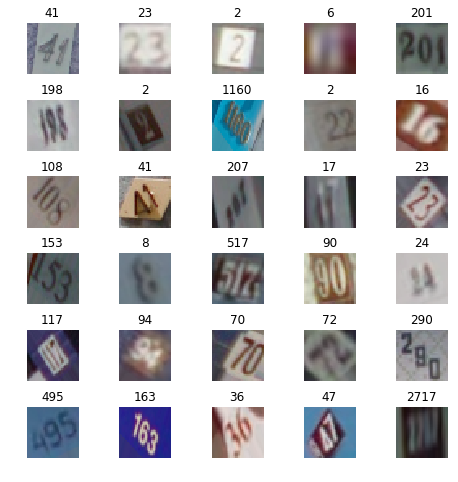

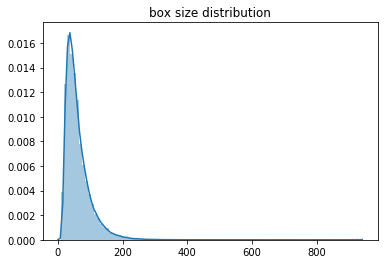

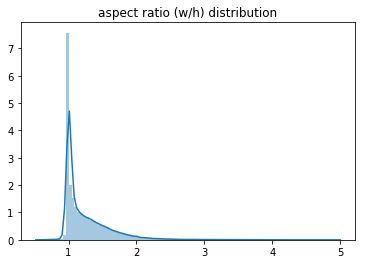

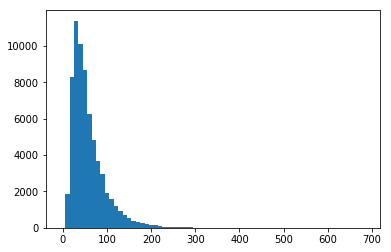

In [11]:
from utilities import plot_images
random_img_indices = np.random.choice(df_32x32.shape[0]//2-1, size=30, replace=False)

images=df_32x32.iloc[random_img_indices]['image']
labels=df_32x32.iloc[random_img_indices]['y'].values

plot_images.in_grid(images, labels=labels, rows=6, cols=5)

# # - Compare some of above images with original images
# n_compares=5
# images_org=df_main.iloc[random_img_indices[:n_compares]]['image']
# labels_org=df_main.iloc[random_img_indices[:n_compares]]['y'].values

# images_trans=df_32x32.iloc[random_img_indices[:n_compares]]['image']
# labels_trans=df_32x32.iloc[random_img_indices[:n_compares]]['y'].values

# images, labels=[], []
# for i, (img_org, img_trans) in enumerate(zip(images_org, images_trans)):
#     images.append(img_org)
#     images.append(img_trans)
#     labels.append(labels_org[i])
#     labels.append(labels_trans[i])
# images=np.array(images)
# labels = np.array(labels)
# plot_images.in_grid(images, labels=labels, rows=n_compares, cols=2)

# - check box sizes used to crop (will help later to decide during testing)
box_sizes = df_32x32['box_size'].values
aspect_WbyH_ratios = df_32x32['aspect_WbyH'].values
box_sizes, aspect_WbyH_ratios = np.hstack(box_sizes), np.hstack(aspect_WbyH_ratios)
sns.distplot(box_sizes, bins=100)
plt.title('box size distribution')
plt.show()
sns.distplot(aspect_WbyH_ratios, bins=100)
plt.title('aspect ratio (w/h) distribution')
plt.show()

dist_boxes = np.histogram(box_sizes, bins=np.arange(0,700,10)) # distribution of boxes ([0]: p vals, [1]: bins)
plt.bar(dist_boxes[1][:-1], dist_boxes[0], 10)
plt.show()

### Generate False image data

In [12]:
# df_32x32_false = digitStruct.getFalseImages_DataFrame(dist_boxes, size=32, 
#                                                      total_crops=df_32x32.shape[0]//2, 
#                                                      Ncrops_PerImage=3, 
#                                                       max_recognizable_digits=5, 
#                                                       grayScale=False,
#                                                       rotationRange=rotationRange)

#### Store False shrunken images on disk

In [13]:
# store_df_32x32_false = pd.HDFStore('store_df_32x32_false.h5')
# store_df_32x32_false.put('df_32x32_false', df_32x32_false)
# store_df_32x32_false.close()

#### load False shrunken images (32x32)

In [14]:
with pd.HDFStore('store_df_32x32_false.h5') as store_df_32x32_false:
    df_32x32_false = store_df_32x32_false.get('df_32x32_false')

print('Dataframe shape',df_32x32_false.shape)

Dataframe shape (32370, 5)


#### Viz False images

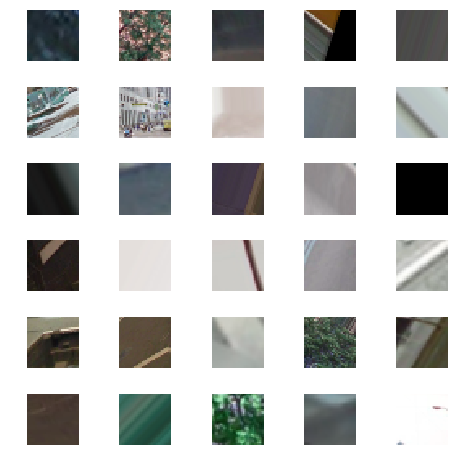

In [15]:
random_img_indices = np.random.choice(df_32x32_false.shape[0], size=30, replace=False)

images=df_32x32_false.iloc[random_img_indices]['image']
labels=df_32x32_false.iloc[random_img_indices]['y'].values

plot_images.in_grid(images, labels=labels, rows=6, cols=5)

### Concatenate True and False images

In [16]:
df_32x32=df_32x32.append(df_32x32_false)
print('now shape of dataset',df_32x32.shape)

now shape of dataset (99174, 5)


#### Viz completed dataset

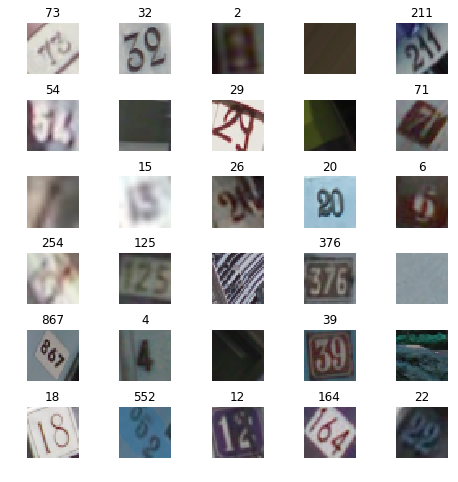

In [17]:
from utilities import plot_images
random_img_indices = np.random.choice(df_32x32.shape[0], size=30, replace=False)

images=df_32x32.iloc[random_img_indices]['image']
labels=df_32x32.iloc[random_img_indices]['y'].values

plot_images.in_grid(images, labels=labels, rows=6, cols=5)

### Building Network

In [18]:
# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K

import keras
from keras.layers import Conv2D, Activation, PReLU, LeakyReLU, MaxPooling2D, LocallyConnected2D, Input, Dense, Dropout, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant, RandomNormal, RandomUniform, glorot_normal, glorot_uniform, he_uniform
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

input_shape=(32,32,3)
num_classes=11
# Hyper-params ###############################
batch_size=256 # 64 also worked well but slow to train...

# w_initializer=lambda : RandomNormal(stddev=0.5) # network seems to be stuck for large number of epochs (checked >70 epochs)
# w_initializer=lambda : glorot_uniform()         # again seems to be stalled (checked > 70 epochs)
w_initializer=lambda : he_uniform()

#    - Learning rate tuning
needLRdecay=True   # decay learning rate or not
initial_lrate= 2e-2 #1e-3 worked well with batch_size=64... 
min_lrate=   1e-5 if needLRdecay else initial_lrate
#     - learning rate scheduling
min_delta=0.001 # for learning rate shaping and EarlyStopping
patience=5
cooldown=3
# def step_decay(epoch): return initial_lrate * (min_lrate/initial_lrate)**((1.+epoch)/(1.+n_epochs))
# LearningRateShaping = lambda : LearningRateScheduler(step_decay)
LearningRateShaping = lambda : ReduceLROnPlateau(monitor='val_y_2_loss',
                                                  factor=0.5, patience=patience, verbose=1, mode='min', 
                                                  epsilon=min_delta, cooldown=cooldown, min_lr=min_lrate)

#   - Regularizations
needEarlyStopping=True

momentum=0.5       # momentum (used for momentum based optimizers only)

n_epochs=300
beta1=0.9 # momentum param 1
beta2=0.999 # momentum param 2

needBN=True # do you need Batch Normalization

#   - optimizer
# optimObj = optimizers.Adam(lr=initial_lrate, beta_1=beta1, beta_2=beta2, epsilon=1e-08, decay=0.0) # DIDnt work well with lr 3e-2
optimObj = optimizers.SGD(lr=initial_lrate, momentum=momentum, decay=0.0, nesterov=True)
# optimObj = optimizers.Nadam(lr=initial_lrate, beta_1=beta1, beta_2=beta2, epsilon=1e-08, schedule_decay=0.004) # DIDnt work well with lr 3e-2

#   - Activation function
# Activation_func = lambda x: Activation('relu')(x)
Activation_func = lambda x: PReLU(alpha_initializer=Constant(0.25))(x) # <-- Important



#   - Train<->Val Split
validation_split=0.15

###############################################

# RGB image in
img_in = Input(shape=input_shape, name="image_input") 

# Block 1
x = Conv2D(64, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block1_conv1')(img_in)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block1_conv2')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x=Dropout(0.25)(x)

# Block 2
x = Conv2D(128, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block2_conv1')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(128, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block2_conv2')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
x=Dropout(0.25)(x)

# Block 3
x = Conv2D(256, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block3_conv1')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(256, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block3_conv2')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(256, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block3_conv3')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x=Dropout(0.25)(x)

# Block 4
x = Conv2D(512, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block4_conv1')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block4_conv2')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block4_conv3')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
x=Dropout(0.25)(x)

# Block 5
x = Conv2D(512, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block5_conv1')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block5_conv2')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = Conv2D(512, (3, 3), padding='same', kernel_initializer=w_initializer(), name='block5_conv3')(x)
if needBN: x=BatchNormalization()(x)
x=Activation_func(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
x=Dropout(0.25)(x)

# - Flatten
x=Flatten()(x)

# 9,10 y_1 Dense-BN-ReLU-Dropout-Dense-BN-ReLU-Dropout-(softmax)
#  - Dense 1
y=Dense(3072, kernel_initializer=w_initializer())(x)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
#  - Dense 2
y=Dense(3072, kernel_initializer=w_initializer())(y)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
# - Out 1
y_1=Dense(num_classes, activation='softmax', name='y_1')(y)

# 9,10 y_2 Dense-BN-ReLU-Dropout-Dense-BN-ReLU-Dropout-(softmax)
#  - Dense 1
y=Dense(3072, kernel_initializer=w_initializer())(x)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
#  - Dense 2
y=Dense(3072, kernel_initializer=w_initializer())(y)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
# - Out 2
y_2=Dense(num_classes, activation='softmax', name='y_2', kernel_initializer=w_initializer())(y)

# 9,10 y_3 Dense-BN-ReLU-Dropout-Dense-BN-ReLU-Dropout-(softmax)
#  - Dense 1
y=Dense(3072, kernel_initializer=w_initializer())(x)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
#  - Dense 2
y=Dense(3072, kernel_initializer=w_initializer())(y)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
# - Out 3
y_3=Dense(num_classes, activation='softmax', name='y_3', kernel_initializer=w_initializer())(y)

# 9,10 y_4 Dense-BN-ReLU-Dropout-Dense-BN-ReLU-Dropout-(softmax)
#  - Dense 1
y=Dense(3072, kernel_initializer=w_initializer())(x)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
#  - Dense 2
y=Dense(3072, kernel_initializer=w_initializer())(y)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
# - Out 4
y_4=Dense(num_classes, activation='softmax', name='y_4', kernel_initializer=w_initializer())(y)

# 9,10 y_5 Dense-BN-ReLU-Dropout-Dense-BN-ReLU-Dropout-(softmax)
#  - Dense 1
y=Dense(3072, kernel_initializer=w_initializer())(x)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
#  - Dense 2
y=Dense(3072, kernel_initializer=w_initializer())(y)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
# - Out 5
y_5=Dense(num_classes, activation='softmax', name='y_5', kernel_initializer=w_initializer())(y)

# 9,10 Ndigits Dense-BN-ReLU-Dropout-Dense-BN-ReLU-Dropout-(softmax)
#  - Dense 1
y=Dense(3072, kernel_initializer=w_initializer())(x)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
#  - Dense 2
y=Dense(3072, kernel_initializer=w_initializer())(y)
if needBN: y=BatchNormalization()(y)
y=Activation_func(y)
y=Dropout(0.5)(y)
# - Out 5
Ndigits=Dense(max_recognizable_digits+2, activation='softmax', name='Ndigits', 
              kernel_initializer=w_initializer())(y)

Using TensorFlow backend.


### Define model and Compile

In [19]:
model = Model(inputs=[img_in], outputs=[Ndigits, y_1, y_2, y_3, y_4, y_5])

model.compile(optimizer=optimObj,
              loss={'Ndigits': 'categorical_crossentropy', 
                    'y_1': 'categorical_crossentropy',
                    'y_2': 'categorical_crossentropy',
                    'y_3': 'categorical_crossentropy',
                    'y_4': 'categorical_crossentropy',
                    'y_5': 'categorical_crossentropy'},
              metrics=['accuracy'],
             )
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         block1_conv1[0][0]               
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 64)   65536       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
block1_con

### Get {X, y}

In [20]:
df_32x32.columns

Index(['N', 'aspect_WbyH', 'box_size', 'image', 'y'], dtype='object')

Check some random y samples
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
6 :	 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
2 :	 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
-1 :	 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0 :	 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 image input shape (99174, 32, 32, 3)


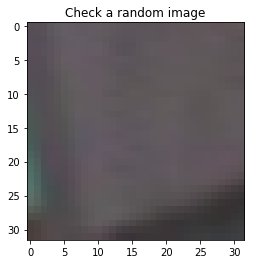

In [21]:
getY = lambda i: np.vstack(df_32x32['y'].values)[:,i]
labels_y_1 = keras.utils.to_categorical(getY(0), num_classes)
labels_y_2 = keras.utils.to_categorical(getY(1), num_classes)
labels_y_3 = keras.utils.to_categorical(getY(2), num_classes)
labels_y_4 = keras.utils.to_categorical(getY(3), num_classes)
labels_y_5 = keras.utils.to_categorical(getY(4), num_classes)

labels_Ndigits = keras.utils.to_categorical(df_32x32['N'].values, max_recognizable_digits+2) # 0-5 and >5

print('Check some random y samples')
ind_rand = np.random.choice(getY(1).shape[0], 10)
for Lab,oneHot in zip(getY(1)[ind_rand], labels_y_2[ind_rand]):
    print(Lab,":\t",oneHot)

images = np.vstack(df_32x32['image'].values).reshape(-1,32,32,3)
print('\n image input shape', images.shape)
plt.imshow(images[np.random.choice(images.shape[0])])
plt.title('Check a random image')
plt.show()

### Train

In [22]:
# - Preprocessing
#  - images (mean subtraction and normalize to max 1.0)
images_processed = PreProcImg.img_meanSubtraction_compressTo1p0(images)
#  - Random shuffle
ind_shuffled = np.random.permutation(images_processed.shape[0]) # shuffled indices
#    - X shuffle
images_processed = images_processed[ind_shuffled]
#    - y shuffle
labels_Ndigits = labels_Ndigits[ind_shuffled] 
labels_y_1 = labels_y_1[ind_shuffled]
labels_y_2 = labels_y_2[ind_shuffled]
labels_y_3 = labels_y_3[ind_shuffled]
labels_y_4 = labels_y_4[ind_shuffled]
labels_y_5 = labels_y_5[ind_shuffled]

# - Callbacks
callback_list=[]
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
#   - Early stopping
early_stopping = EarlyStopping(monitor='val_y_2_loss', 
                               min_delta=min_delta, 
                               patience=4*(patience+cooldown), 
                               mode='min') # stop of no improvement in about 3 learning rate decrements.
if needEarlyStopping: callback_list.append(early_stopping)
#   - Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_y_2_acc', verbose=1, save_best_only=True, mode='max')
callback_list.append(checkpoint)
#   - learning rate scheduler
lrate_schedule = LearningRateShaping()
callback_list.append(lrate_schedule)
#   - TensorBoard
tbCallBack = TensorBoard(log_dir='./tensorboard_logs', histogram_freq=20, batch_size=batch_size, write_graph=True, write_images=True)
# callback_list.append(tbCallBack)


# - Train
history_callback = model.fit({'image_input': images_processed}, # inputs
                              { 'Ndigits': labels_Ndigits, # outputs
                                'y_1': labels_y_1, 
                                'y_2': labels_y_2,
                                'y_3': labels_y_3,
                                'y_4': labels_y_4,
                                'y_5': labels_y_5},
                              epochs=n_epochs,
                              batch_size=batch_size,
                              validation_split=validation_split,
                              shuffle=True,
                              callbacks=callback_list
                             )

Train on 84297 samples, validate on 14877 samples
Epoch 1/300
84297/84297 [==============================] - 87s 1ms/step - loss: 5.2652 - Ndigits_loss: 0.8545 - y_1_loss: 1.6026 - y_2_loss: 1.6843 - y_3_loss: 0.8982 - y_4_loss: 0.2029 - y_5_loss: 0.0227 - Ndigits_acc: 0.6685 - y_1_acc: 0.4582 - y_2_acc: 0.4440 - y_3_acc: 0.7905 - y_4_acc: 0.9679 - y_5_acc: 0.9963 - val_loss: 4.9972 - val_Ndigits_loss: 0.7247 - val_y_1_loss: 1.4994 - val_y_2_loss: 1.5757 - val_y_3_loss: 0.8421 - val_y_4_loss: 0.2496 - val_y_5_loss: 0.1057 - val_Ndigits_acc: 0.7275 - val_y_1_acc: 0.4906 - val_y_2_acc: 0.4639 - val_y_3_acc: 0.7942 - val_y_4_acc: 0.9650 - val_y_5_acc: 0.9851
Epoch 2/300
84297/84297 [==============================] - 77s 910us/step - loss: 4.3683 - Ndigits_loss: 0.5475 - y_1_loss: 1.4250 - y_2_loss: 1.4882 - y_3_loss: 0.7486 - y_4_loss: 0.1555 - y_5_loss: 0.0036 - Ndigits_acc: 0.7812 - y_1_acc: 0.4988 - y_2_acc: 0.4796 - y_3_acc: 0.7977 - y_4_acc: 0.9707 - y_5_acc: 0.9998 - val_loss: 4.507

84297/84297 [==============================] - 76s 903us/step - loss: 1.5717 - Ndigits_loss: 0.1520 - y_1_loss: 0.4481 - y_2_loss: 0.5438 - y_3_loss: 0.3369 - y_4_loss: 0.0888 - y_5_loss: 0.0022 - Ndigits_acc: 0.9455 - y_1_acc: 0.8531 - y_2_acc: 0.8166 - y_3_acc: 0.8889 - y_4_acc: 0.9744 - y_5_acc: 0.9998 - val_loss: 1.4593 - val_Ndigits_loss: 0.1620 - val_y_1_loss: 0.3714 - val_y_2_loss: 0.4743 - val_y_3_loss: 0.3130 - val_y_4_loss: 0.1137 - val_y_5_loss: 0.0248 - val_Ndigits_acc: 0.9466 - val_y_1_acc: 0.8835 - val_y_2_acc: 0.8471 - val_y_3_acc: 0.9035 - val_y_4_acc: 0.9715 - val_y_5_acc: 1.0000
Epoch 18/300
84297/84297 [==============================] - 76s 899us/step - loss: 1.5058 - Ndigits_loss: 0.1453 - y_1_loss: 0.4273 - y_2_loss: 0.5201 - y_3_loss: 0.3238 - y_4_loss: 0.0871 - y_5_loss: 0.0020 - Ndigits_acc: 0.9488 - y_1_acc: 0.8583 - y_2_acc: 0.8261 - y_3_acc: 0.8933 - y_4_acc: 0.9747 - y_5_acc: 0.9998 - val_loss: 1.7996 - val_Ndigits_loss: 0.2464 - val_y_1_loss: 0.3981 - val_y

84297/84297 [==============================] - 76s 905us/step - loss: 1.1306 - Ndigits_loss: 0.0979 - y_1_loss: 0.3203 - y_2_loss: 0.3895 - y_3_loss: 0.2470 - y_4_loss: 0.0740 - y_5_loss: 0.0019 - Ndigits_acc: 0.9654 - y_1_acc: 0.8946 - y_2_acc: 0.8692 - y_3_acc: 0.9182 - y_4_acc: 0.9768 - y_5_acc: 0.9998 - val_loss: 1.2722 - val_Ndigits_loss: 0.1539 - val_y_1_loss: 0.2981 - val_y_2_loss: 0.4081 - val_y_3_loss: 0.2708 - val_y_4_loss: 0.0989 - val_y_5_loss: 0.0424 - val_Ndigits_acc: 0.9517 - val_y_1_acc: 0.9091 - val_y_2_acc: 0.8726 - val_y_3_acc: 0.9169 - val_y_4_acc: 0.9740 - val_y_5_acc: 1.0000
Epoch 26/300
84297/84297 [==============================] - 76s 905us/step - loss: 1.1034 - Ndigits_loss: 0.0986 - y_1_loss: 0.3088 - y_2_loss: 0.3790 - y_3_loss: 0.2413 - y_4_loss: 0.0739 - y_5_loss: 0.0018 - Ndigits_acc: 0.9643 - y_1_acc: 0.8992 - y_2_acc: 0.8738 - y_3_acc: 0.9196 - y_4_acc: 0.9770 - y_5_acc: 0.9998 - val_loss: 1.2324 - val_Ndigits_loss: 0.1476 - val_y_1_loss: 0.3007 - val_y

KeyboardInterrupt: 

### Save Model

In [ ]:
modelName = 'multi_digit_classifier_FullyTrainVGG16_Dataset1_2xCrops_AugmentedWithFalseImages_withRandomRotations'

from keras.models import load_model
model.save('./trained_models/{}.h5'.format(modelName))

df_results = pd.DataFrame(columns=list(history_callback.history.keys()))
for metric in df_results.columns:
    df_results[metric]=history_callback.history[metric]
df_results.to_csv('./resultMetric_dump/{}.csv'.format(modelName))

In [ ]:
model.summary()

In [ ]:
# del model